# RQ3: Reskilling intensity
Felix Zaussinger | 15.06.2021

## Core Analysis Goal(s)
1. How close are occupations likely less demanded in a green transition to those being more demanded? (~ reskilling intensity)
2. Further disaggregate the analysis to the ISCO-08 1-digit level groups?

## Key Insight(s)
1. Ranking of average similarities is surprising. Only looking at occupation similarity, brown occupations are on average closer to green occupations than neutral occupations.
    - Neutral & Green
    - Brown & Green
    - Brown & Neutral
2. Cross-pair differences are statistically significant at p < 0.001
3. Between-pair differences not significant at p < 0.001 are neutral-green and green-brown
4. Results are not robust to changing the similarity matrix (upeksha vs kanders).
using Upeksha's matrix, green-brown is closest, followed by green-neutral and neutral-brown

In [184]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
import scipy
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [185]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [186]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [187]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018_v2 = df_metadata.greenness_vona_2018_v2.fillna(0)

# convert job zone to categorical var
#df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

#### Remove military occupations from df_metadata
21 occupations in total, all coded as neutral

ISCO codes (n=21)
- 110: n=12
- 210: n=4
- 310: n=5

In [188]:
cond = (df_metadata.isco_level_4 == 110) | (df_metadata.isco_level_4 == 210) | (df_metadata.isco_level_4 == 310)

cond.name = "military"
df_cond = cond.reset_index()
df_cond.to_csv(os.path.join(data_interim, "esco_military_occupations.csv"),)

# for re-indexing the sim matrices
non_military_indices = df_cond[~df_cond.military].index.values

df_metadata = df_metadata.loc[~cond]
df_metadata = df_metadata.reset_index(drop=True)

In [189]:
df_metadata

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,-206000.0,-748000.0,322000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0
2917,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0
2918,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0
2919,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0


In [190]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

In [191]:
xn, yn = np.meshgrid(non_military_indices, non_military_indices)

sim_kanders_nm = sim_kanders[xn, yn]
sim_kanders_nm.tofile(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined_no_military.npy")
)

In [192]:
# brown occupations
df_brown = pd.read_csv(
    os.path.join(data_interim, "occupations_brown_vona_esco.csv"),
    index_col=0
)

In [193]:
# add brown occupation classification
df_brown["is_brown"] = np.ones(df_brown.shape[0], dtype=bool)

# merge
df_metadata = pd.merge(
    df_metadata,
    df_brown[["concept_uri", "is_brown"]],
    how="left",
    on="concept_uri"
)

df_metadata.is_brown = df_metadata.is_brown.fillna(False)
df_metadata["is_green"] = df_metadata.greenness_vona_2018_v2 > 0
df_metadata["is_neutral"] = (df_metadata.is_green == False) & (df_metadata.is_brown == False)

# drop duplicates
df_metadata = df_metadata.drop_duplicates(subset=["concept_uri"])

# 8ung: there are 30 occupations that have been matched to both brown and green
# the neutral occupations are fine! have to make decision on where to map the
# ambiguous cases
query = (df_metadata.is_brown == True) & (df_metadata.is_green == True)

df_metadata.query("is_brown == True & is_green == True").to_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn_ambiguous_cases.csv")
)

# --> define ambiguous cases as brown as a first solution
df_metadata.loc[query, "is_green"] = False
df_metadata = df_metadata.reset_index(drop=True)

In [194]:
query = (df_metadata.is_brown == True) & (df_metadata.is_green == True)
df_metadata.loc[query]

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral


In [195]:
df_metadata.to_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv")
)

#### Number of green/brown/neutral occupations per ISCO 1-digit group

In [196]:
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

In [197]:
# table for overleaf document
cols = ["preferred_label", "isco_level_1", "is_brown", "is_green", "is_neutral"]
df_sub = df_metadata[cols]
#df_sub["isco_level_1_txt"] = df_sub.isco_level_1.replace(isco_lvl1_mapping)

df_sub_counts = df_sub.groupby("isco_level_1").sum().reset_index()
df_sub_counts["isco_level_1_txt"] = [isco_lvl1_mapping[val] for val in df_sub_counts.isco_level_1.values]

count_sums =  df_sub_counts[["is_brown", "is_green", "is_neutral"]].sum(axis=1)
col_order = ["isco_level_1", "isco_level_1_txt", "is_brown"]
count_sums
df_sub_counts["is_brown_pc"] = (df_sub_counts["is_brown"] / count_sums) * 100
df_sub_counts["is_green_pc"] = (df_sub_counts["is_green"] / count_sums) * 100
df_sub_counts["is_neutral_pc"] = (df_sub_counts["is_neutral"] / count_sums) * 100

# store
df_sub_counts.to_excel(
    os.path.join(data_processed, "occupation_group_by_isco_lvl1.xlsx")
)

## Iterate over all occupations and compute avg reskilling intensities

In [232]:
ids_brown = df_metadata.loc[df_metadata.is_brown == True, :].index.values
ids_green = df_metadata.loc[df_metadata.is_green == True, :].index.values
ids_neutral = df_metadata.loc[df_metadata.is_neutral == True, :].index.values
len(ids_neutral) * len(ids_neutral)

4519876

#### Case 1: Brown - Green

In [199]:
sim_matrix = sim_kanders_nm

In [200]:
sim_brown_green = []
for b in tqdm(ids_brown):
    for g in ids_green:
        sim_brown_green.append(sim_matrix[b, g])

np.mean(sim_brown_green)

sim_green_brown = []
for b in tqdm(ids_brown):
    for g in ids_green:
        sim_green_brown.append(sim_matrix[g, b])

np.mean(sim_green_brown)

100%|██████████| 393/393 [00:00<00:00, 4036.57it/s]


0.15751202576145415

#### Case 2: Brown - Neutral

In [201]:
sim_brown_neutral = []
for b in tqdm(ids_brown):
    for n in ids_neutral:
        sim_brown_neutral.append(sim_matrix[b, n])

np.mean(sim_brown_neutral)

sim_neutral_brown = []
for b in tqdm(ids_brown):
    for n in ids_neutral:
        sim_neutral_brown.append(sim_matrix[n, b])

np.mean(sim_neutral_brown)

100%|██████████| 393/393 [00:00<00:00, 869.25it/s]


0.14546531596481496

#### Case 3: Neutral - Green

In [202]:
sim_neutral_green = []
for n in tqdm(ids_neutral):
    for g in ids_green:
        sim_neutral_green.append(sim_matrix[n, g])

np.mean(sim_neutral_green)

sim_green_neutral = []
for n in tqdm(ids_neutral):
    for g in ids_green:
        sim_green_neutral.append(sim_matrix[g, n])

np.mean(sim_green_neutral)

100%|██████████| 2126/2126 [00:00<00:00, 3224.42it/s]


0.1800804509717037

#### Case 4: all occupations

In [203]:
ids_all = df_metadata.index.values
sim_all = []
for i in tqdm(ids_all):
    for j in ids_all:
        sim_all.append(sim_matrix[i, j])

100%|██████████| 2921/2921 [00:04<00:00, 691.76it/s]


In [204]:
np.mean(sim_all)
np.median(sim_all)

0.16285710620229538

#### Combine in single df

In [205]:
def pad(seq, target_length, padding=None):
    length = len(seq)
    seq.extend([padding] * (target_length - length))
    return seq

In [206]:
df = pd.DataFrame(index=range(len(sim_neutral_green)))
df["sim_green_brown"] = pad(sim_green_brown, len(sim_neutral_green), np.nan)
df["sim_brown_green"] = pad(sim_brown_green, len(sim_neutral_green), np.nan)

df["sim_brown_neutral"] = pad(sim_brown_neutral, len(sim_neutral_green), np.nan)
df["sim_neutral_brown"] = pad(sim_neutral_brown, len(sim_neutral_green), np.nan)

df["sim_neutral_green"] = pad(sim_neutral_green, len(sim_neutral_green), np.nan)
df["sim_green_neutral"] = pad(sim_green_neutral, len(sim_neutral_green), np.nan)

In [207]:
df2 = pd.DataFrame(index=range(len(sim_all)))

df2["sim_all"] = pad(sim_all, len(sim_all), np.nan)

df2["sim_green_brown"] = pad(sim_green_brown, len(sim_all), np.nan)
df2["sim_brown_green"] = pad(sim_brown_green, len(sim_all), np.nan)

df2["sim_brown_neutral"] = pad(sim_brown_neutral, len(sim_all), np.nan)
df2["sim_neutral_brown"] = pad(sim_neutral_brown, len(sim_all), np.nan)

df2["sim_neutral_green"] = pad(sim_neutral_green, len(sim_all), np.nan)
df2["sim_green_neutral"] = pad(sim_green_neutral, len(sim_all), np.nan)


#### Visualisations

In [208]:
df.median().sort_values(ascending=False)

sim_green_neutral    0.175797
sim_neutral_green    0.175673
sim_brown_green      0.149147
sim_green_brown      0.147058
sim_brown_neutral    0.138211
sim_neutral_brown    0.137566
dtype: float64

In [209]:
df2.median().sort_values(ascending=False)

sim_green_neutral    0.175797
sim_neutral_green    0.175673
sim_all              0.162857
sim_brown_green      0.149147
sim_green_brown      0.147058
sim_brown_neutral    0.138211
sim_neutral_brown    0.137566
dtype: float64

In [210]:
scipy.stats.shapiro(
    df.sim_neutral_green.dropna().values
)

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9559755325317383, pvalue=0.0)

((array([-5.23782824, -5.0716475 , -4.98215775, ...,  4.98215775,
          5.0716475 ,  5.23782824]),
  array([0.        , 0.        , 0.        , ..., 0.99924941, 0.99924941,
         0.99924941])),
 (0.0740522274094382, 0.1692593297357206, 0.9300583784102193))

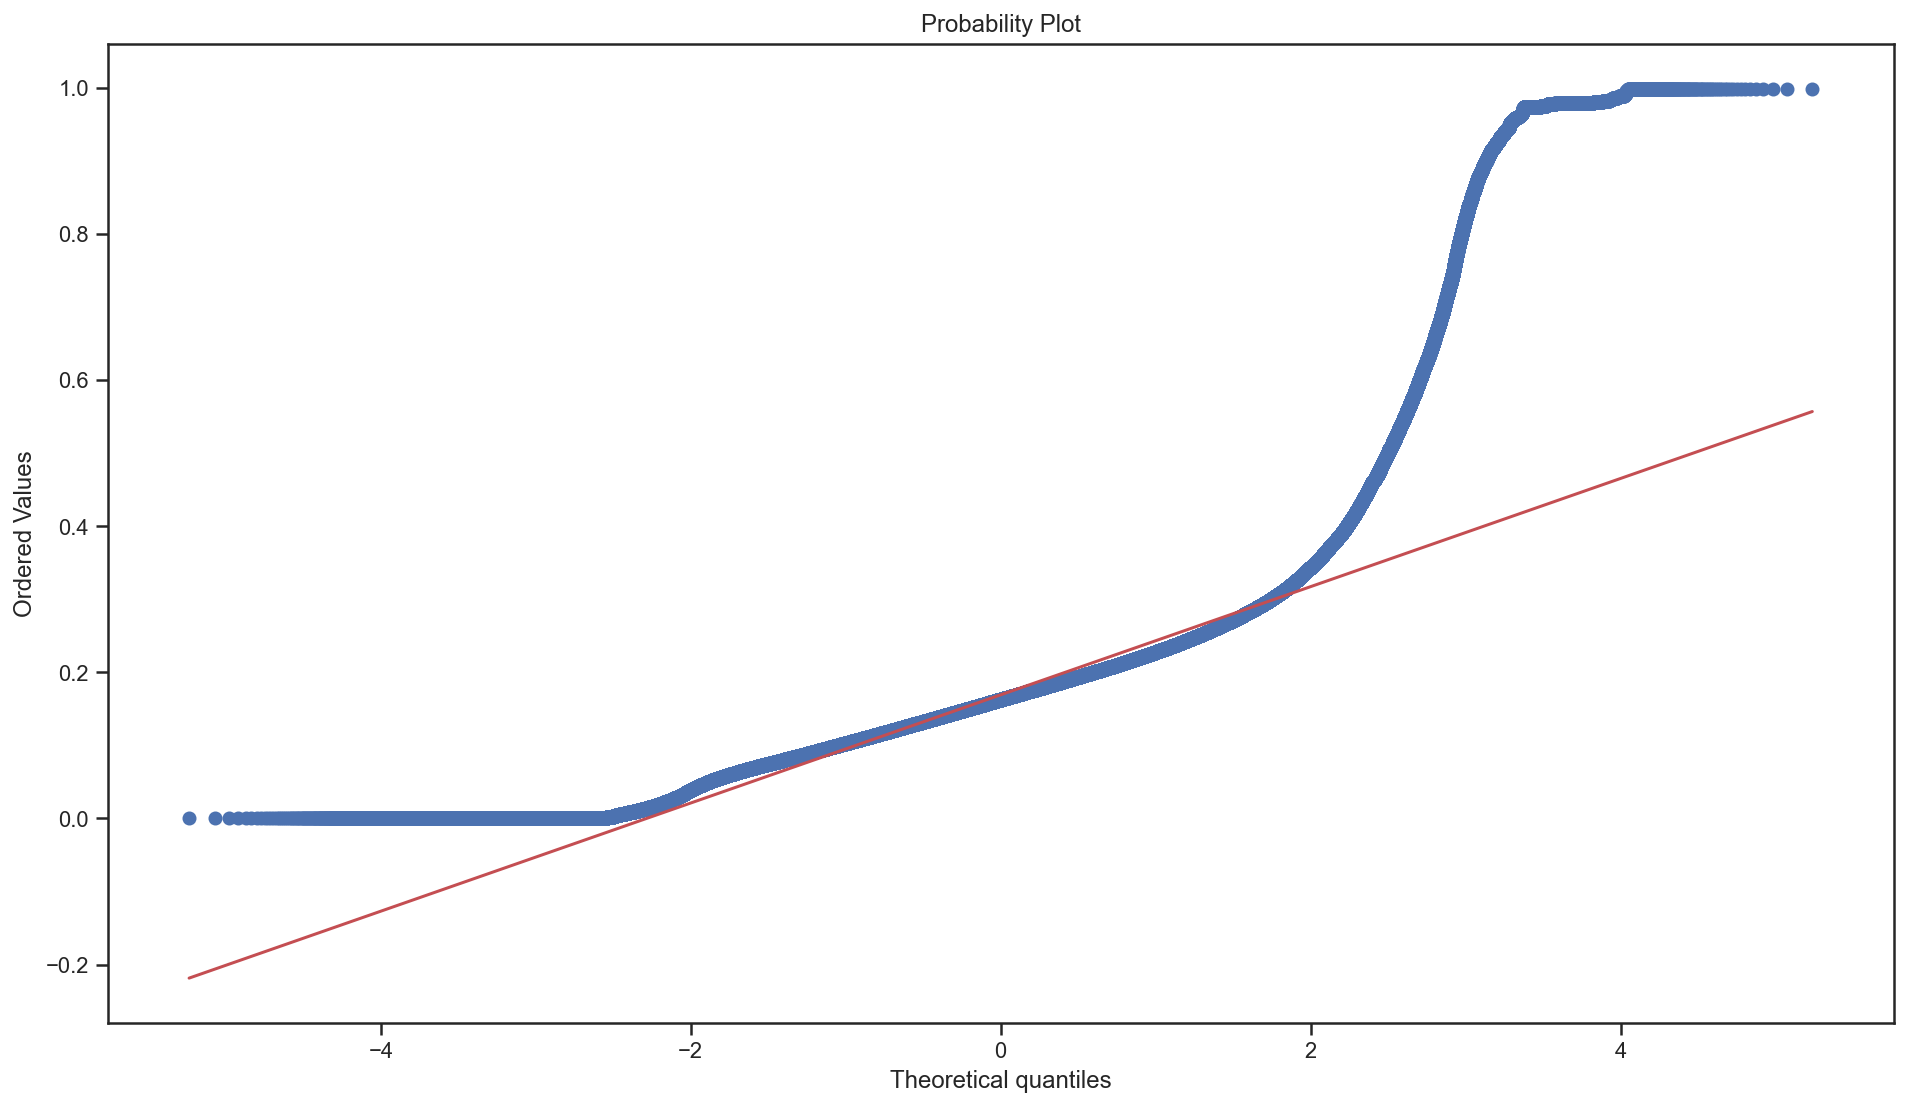

In [211]:
scipy.stats.probplot(df2.sim_all.dropna().values, dist="norm", plot=plt)

In [212]:
df.mean().sort_values(ascending=False)


sim_green_neutral    0.180080
sim_neutral_green    0.179755
sim_brown_green      0.158930
sim_green_brown      0.157512
sim_brown_neutral    0.146484
sim_neutral_brown    0.145465
dtype: float64

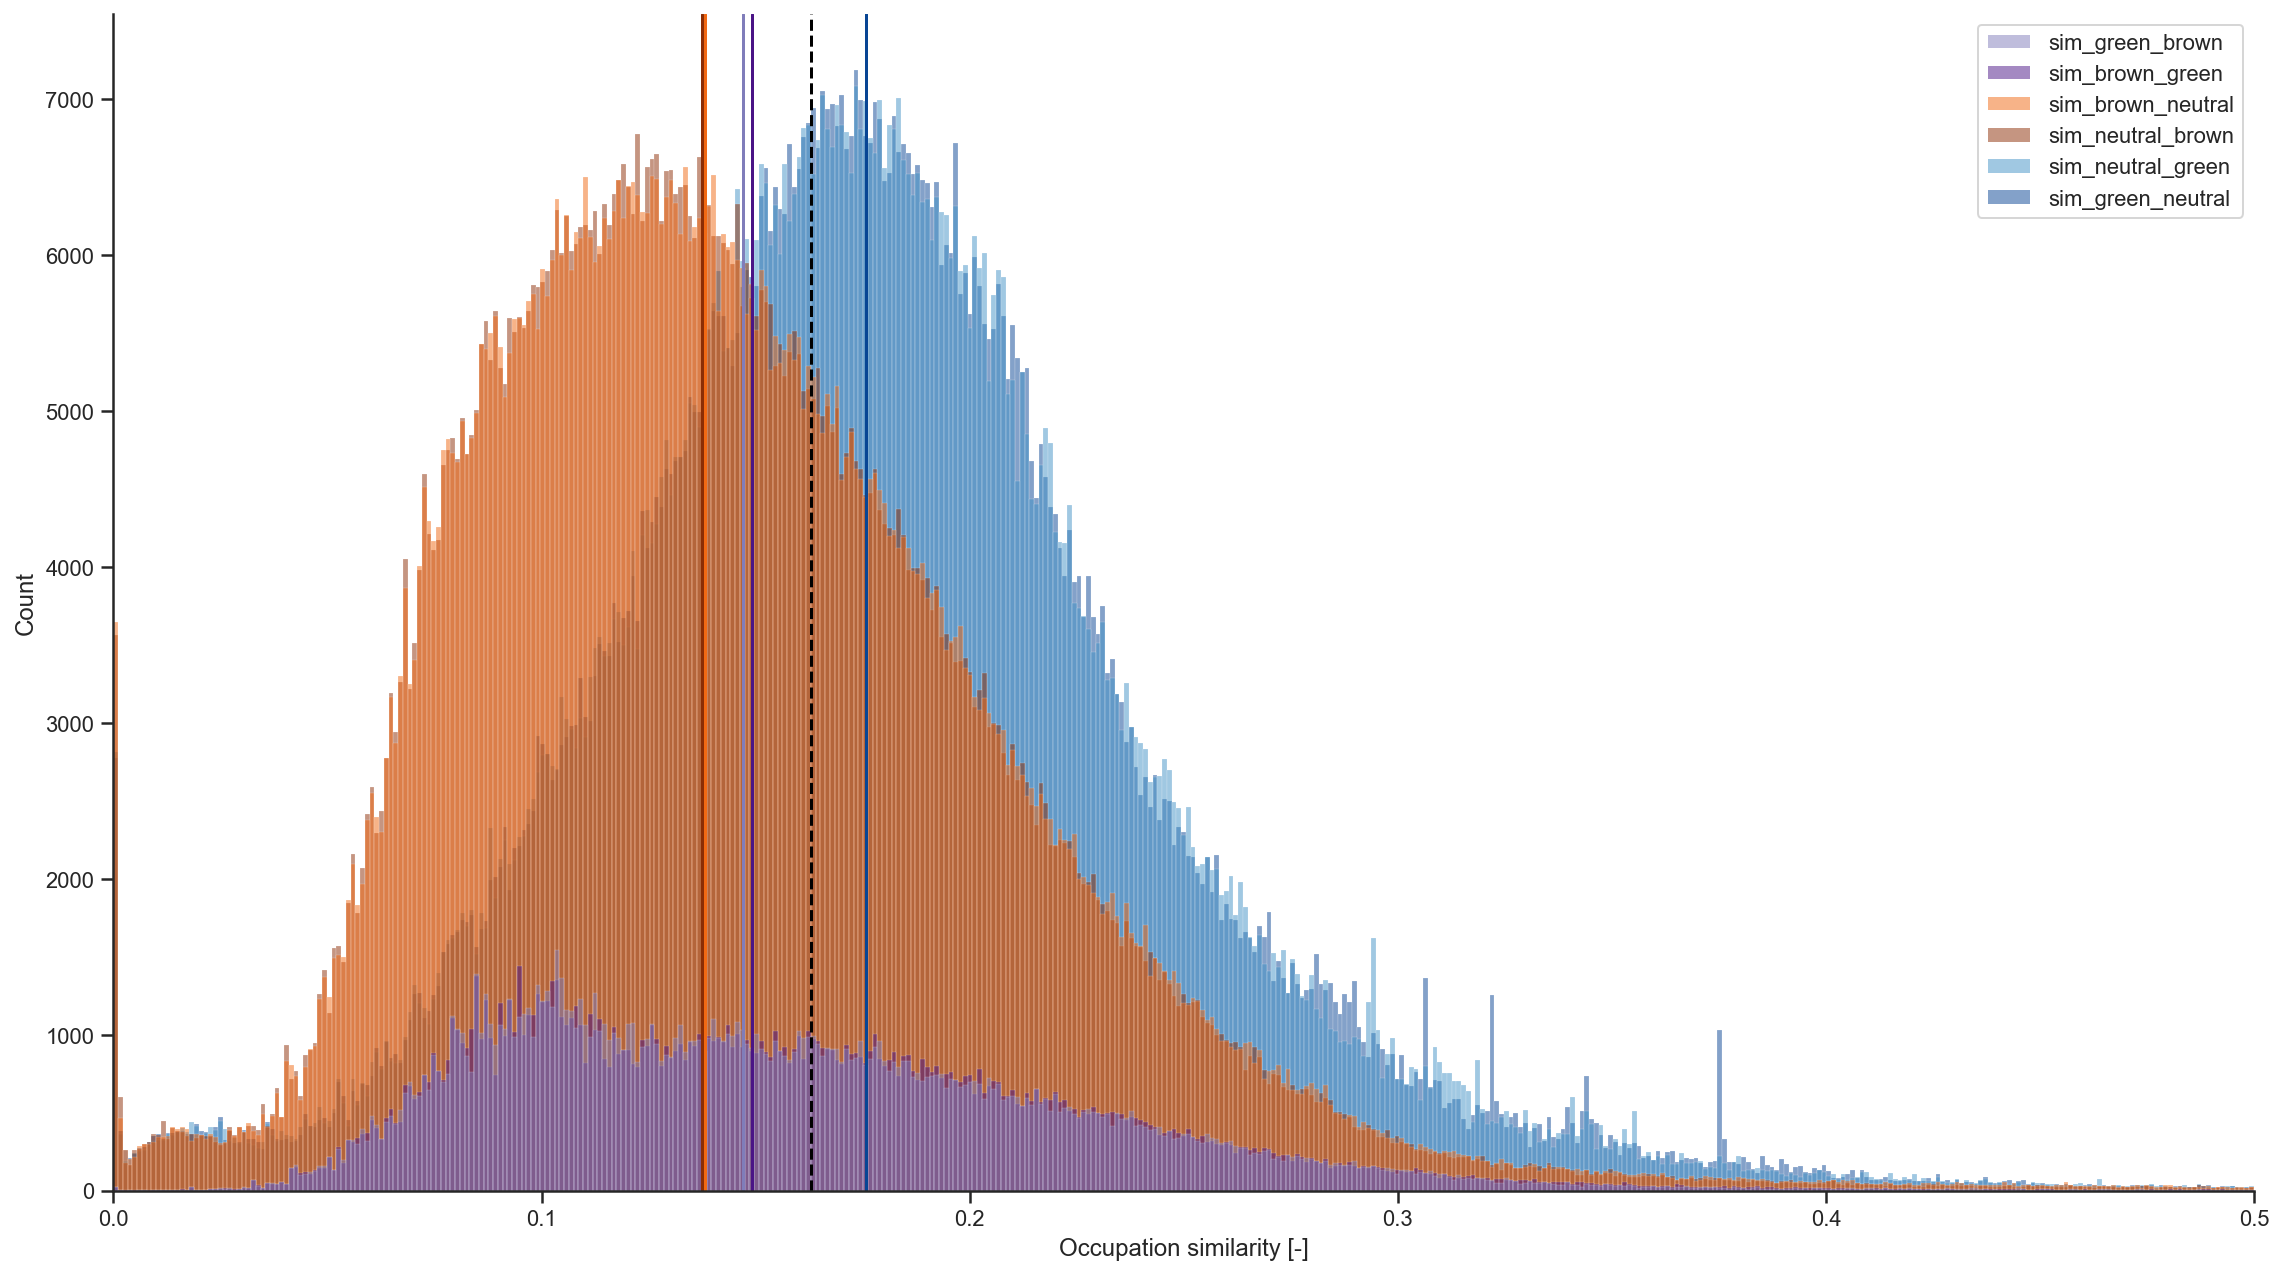

In [213]:
vline_colors = ["#807dba", "#4a1486", "#f16913", "#8c2d04", "#4292c6", "#084594"]
alpha = 0.5

ax = sns.histplot(
    data=df,
    stat="count",
    palette=vline_colors,
    alpha=alpha,
)

for val, color in zip(df.median().values, vline_colors):
    ax.axvline(val, color=color)

# indicate overall median
ax.axvline(df2.sim_all.median(), color="black", linestyle="--", label="sim_all")
ax.set_xlim(0, 0.5)
ax.set_xlabel("Occupation similarity [-]")

sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ3", "avg_sims_histogram_v2.png"),
    bbox_inches="tight",
    dpi=150
)

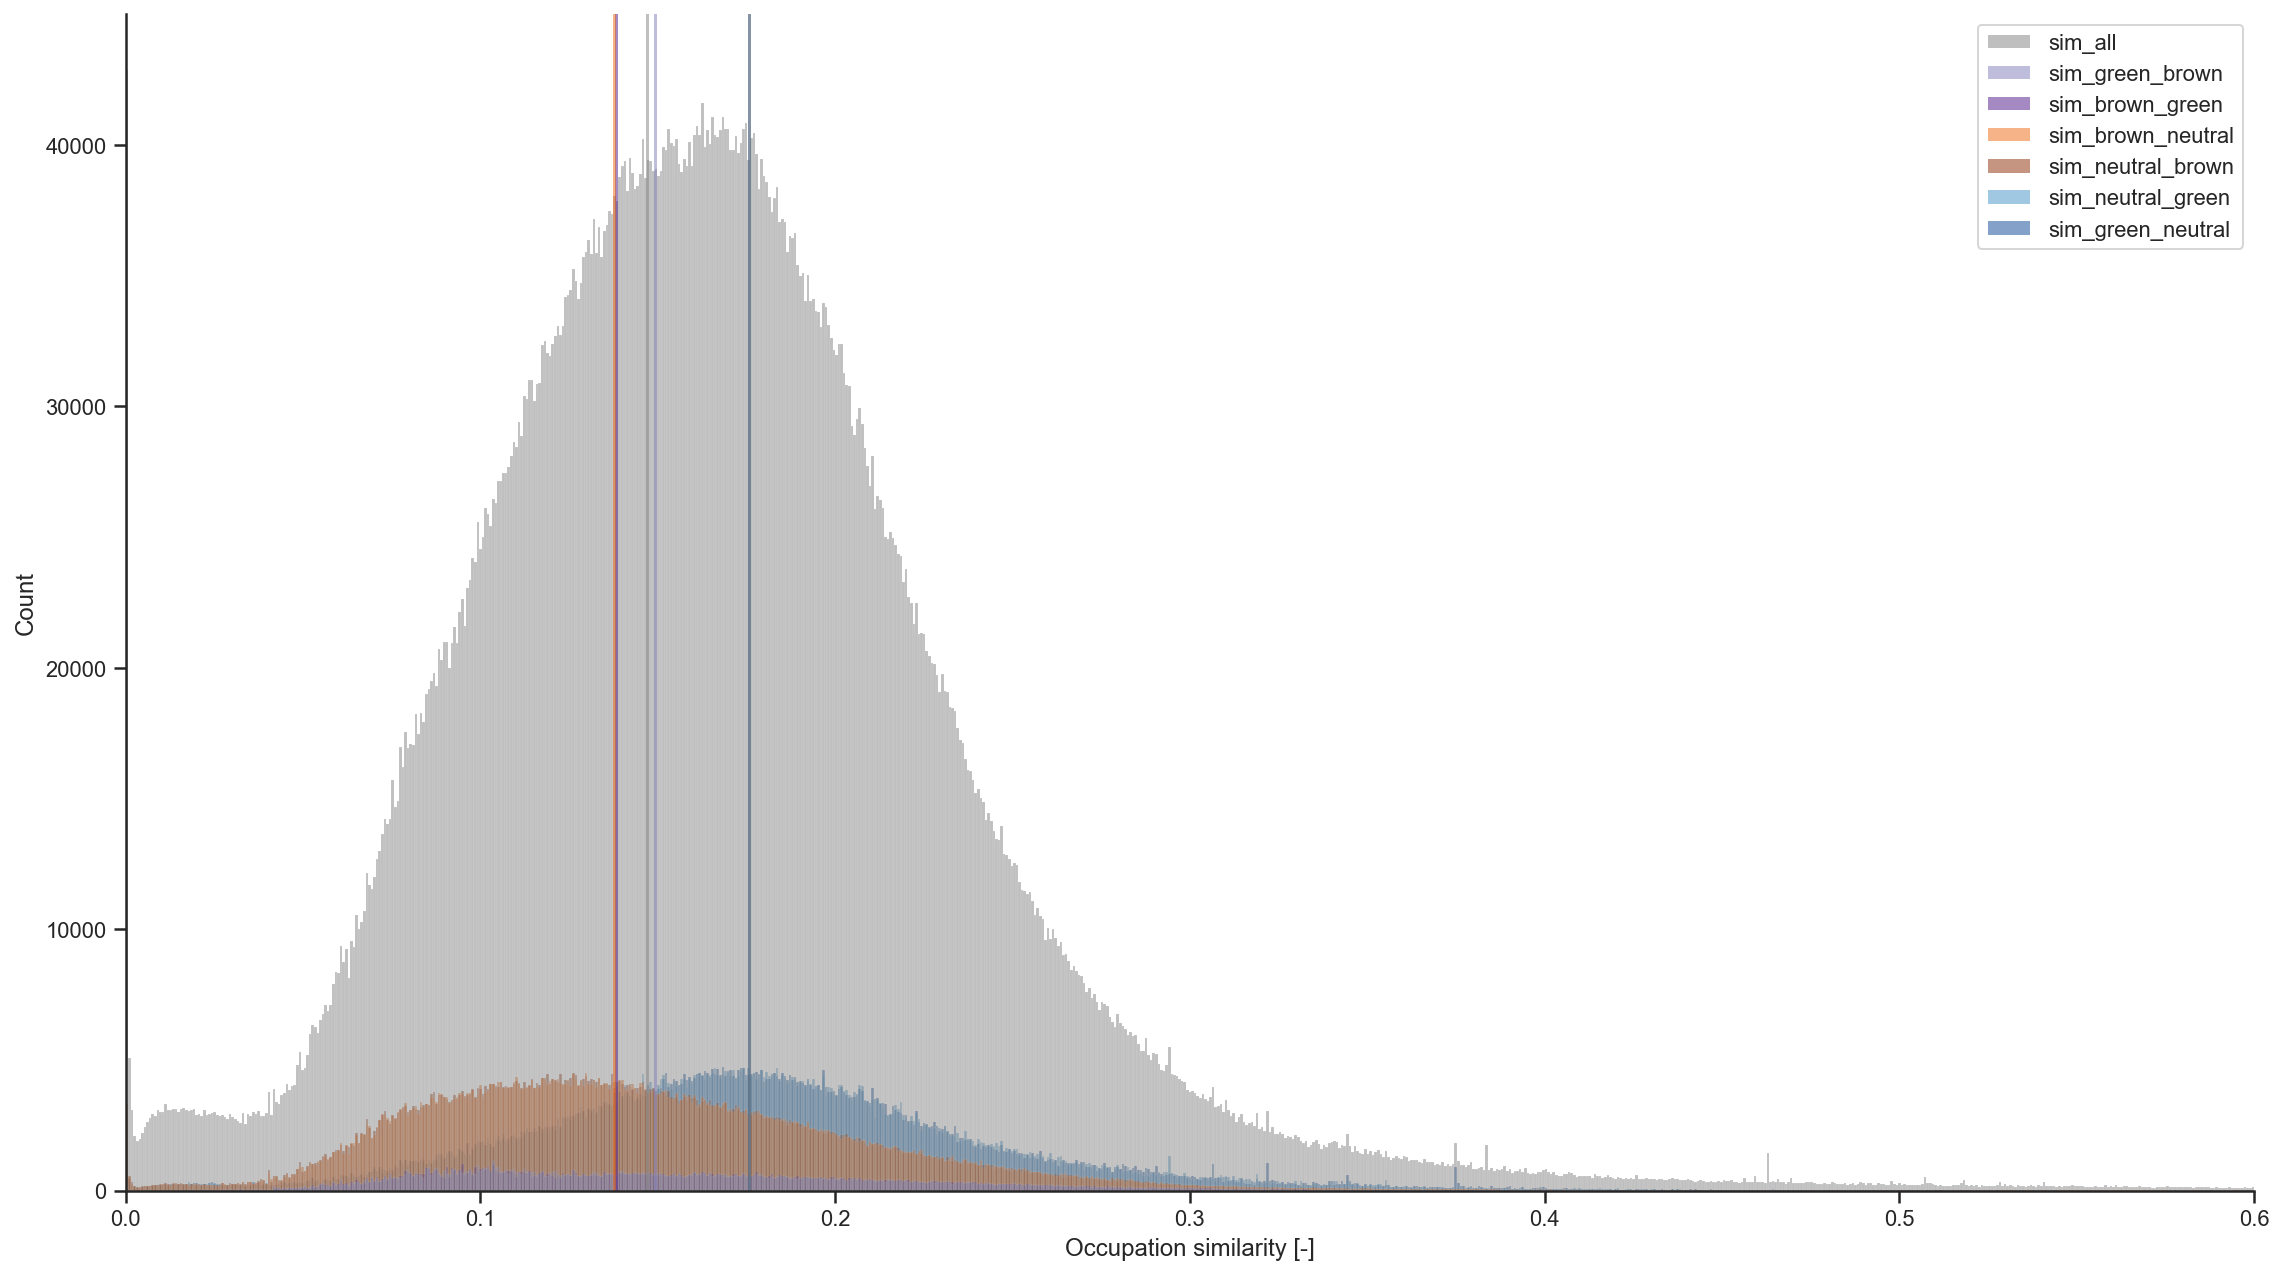

In [214]:
vline_colors = ["grey", "#807dba", "#4a1486", "#f16913", "#8c2d04", "#4292c6", "#084594"]
alpha = 0.5

ax = sns.histplot(
    data=df2,
    stat="count",
    palette=vline_colors,
    alpha=alpha
)

for val, color in zip(df.median().values, vline_colors):
    ax.axvline(val, color=color, alpha=alpha)

ax.set_xlim(0, 0.6)
ax.set_xlabel("Occupation similarity [-]")

sns.despine()
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ3", "avg_sims_histogram_v3.png"),
    bbox_inches="tight",
    dpi=150
)

<AxesSubplot:>

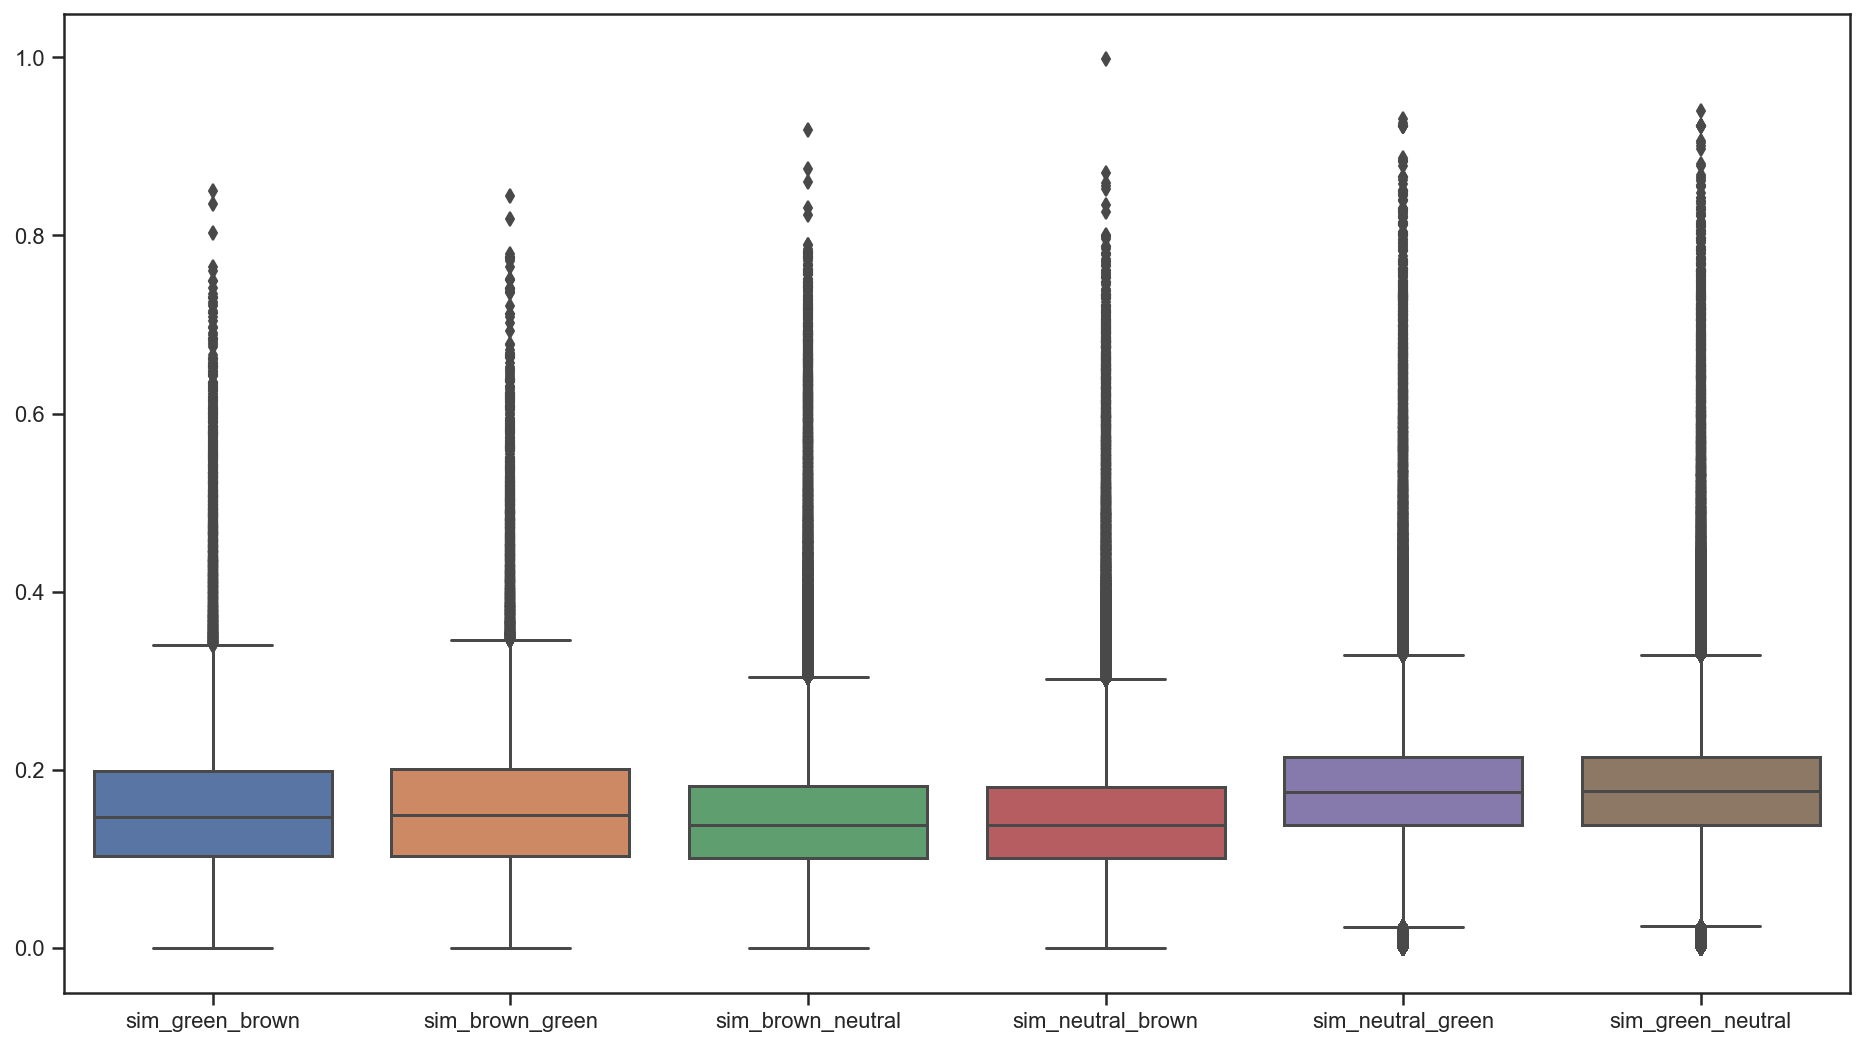

In [215]:
sns.boxplot(
    data=df,
)

#### Difference of central tendencies and post-hoc tests

In [216]:
# ANOVA
scipy.stats.f_oneway(
    df.sim_brown_green.dropna().values,
    df.sim_brown_neutral.dropna().values,
)

F_onewayResult(statistic=4569.041204956295, pvalue=0.0)

In [217]:
# Tukey-HSD
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(
    df.melt().dropna().value,
    df.melt().dropna().variable
)
post_hoc_res = comp.tukeyhsd(alpha=0.001)
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
sim_brown_green,sim_brown_neutral,-0.0124,0.001,-0.0132,-0.0117,True
sim_brown_green,sim_green_brown,-0.0014,0.001,-0.0024,-0.0005,True
sim_brown_green,sim_green_neutral,0.0212,0.001,0.0204,0.0219,True
sim_brown_green,sim_neutral_brown,-0.0135,0.001,-0.0142,-0.0127,True
sim_brown_green,sim_neutral_green,0.0208,0.001,0.0201,0.0216,True
sim_brown_neutral,sim_green_brown,0.011,0.001,0.0103,0.0118,True
sim_brown_neutral,sim_green_neutral,0.0336,0.001,0.0332,0.034,True
sim_brown_neutral,sim_neutral_brown,-0.001,0.001,-0.0014,-0.0006,True
sim_brown_neutral,sim_neutral_green,0.0333,0.001,0.0329,0.0337,True
sim_green_brown,sim_green_neutral,0.0226,0.001,0.0218,0.0233,True


In [218]:
# Kruskall-Wallis H-test
scipy.stats.kruskal(
    df.sim_brown_green.dropna().values,
    df.sim_green_brown.dropna().values,
    df.sim_brown_neutral.dropna().values,
    df.sim_neutral_brown.dropna().values,
    df.sim_green_neutral.dropna().values,
    df.sim_neutral_green.dropna().values,
)

KruskalResult(statistic=265386.6755727759, pvalue=0.0)

In [219]:
import scikit_posthocs as sp

dfm = df.melt(var_name="groups", value_name="values").dropna(subset=["values"])

sp.posthoc_dunn(
    dfm,
    val_col="values",
    group_col="groups",
    p_adjust="bonferroni"
)

,sim_brown_green,sim_brown_neutral,sim_green_brown,sim_green_neutral,sim_neutral_brown,sim_neutral_green
sim_brown_green,1.000000e+00,0.000000e+00,2.539034e-08,0.000000,0.000000e+00,0.000000
sim_brown_neutral,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,2.120933e-11,0.000000
sim_green_brown,2.539034e-08,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000
sim_green_neutral,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.402193
sim_neutral_brown,0.000000e+00,2.120933e-11,0.000000e+00,0.000000,1.000000e+00,0.000000
sim_neutral_green,0.000000e+00,0.000000e+00,0.000000e+00,0.402193,0.000000e+00,1.000000


In [220]:
df2m = df2.melt(var_name="groups", value_name="values").dropna(subset=["values"])

sp.posthoc_dunn(
    df2m,
    val_col="values",
    group_col="groups",
    p_adjust="bonferroni"
)

,sim_all,sim_brown_green,sim_brown_neutral,sim_green_brown,sim_green_neutral,sim_neutral_brown,sim_neutral_green
sim_all,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
sim_brown_green,0.0,1.000000e+00,0.000000e+00,1.096881e-08,0.000000,0.000000e+00,0.000000
sim_brown_neutral,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,1.207432e-11,0.000000
sim_green_brown,0.0,1.096881e-08,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000
sim_green_neutral,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.529789
sim_neutral_brown,0.0,0.000000e+00,1.207432e-11,0.000000e+00,0.000000,1.000000e+00,0.000000
sim_neutral_green,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.529789,0.000000e+00,1.000000


#### Repeat analysis at the level of ISCO-08 1-digit groups (within-groups)
- brown-green vs. brown-neutral (no reverse directions)
- look at within-group similarities

In [221]:
results = {}
for grp, df_isco1 in df_metadata.groupby("isco_level_1"):
    #print(grp, df.shape)

    # get ids of groups in sub-df
    ids_brown = df_isco1.loc[df_isco1.is_brown == True, :].index.values
    ids_green = df_isco1.loc[df_isco1.is_green == True, :].index.values
    ids_neutral = df_isco1.loc[df_isco1.is_neutral == True, :].index.values

    # brown - green
    sim_brown_green = []
    for b in ids_brown:
        for g in ids_green:
            sim_brown_green.append(sim_matrix[b, g])

    sim_brown_neutral = []
    for b in ids_brown:
        for n in ids_neutral:
            sim_brown_neutral.append(sim_matrix[b, n])

    # Kruskall-Wallis H-test
    H, p = scipy.stats.kruskal(sim_brown_green, sim_brown_neutral)

    # store results
    results[grp] = [
        np.nanmedian(sim_brown_green),
        np.nanmedian(sim_brown_neutral),
        len(sim_brown_green),
        len(sim_brown_neutral),
        H,
        p
    ]

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [222]:
df_results = pd.DataFrame.from_dict(
    results, orient="index", columns=[
        "$M_{bg}$", "$M_{bn}$", "$n_{bg}$", "$n_{bn}$", "$H$", "$p$"
    ]
)

df_results = df_results.reset_index().rename(columns={"index": "ISCO"})
df_results["Label"] = [isco_lvl1_mapping[val] for val in df_results.ISCO.values]

col_order = ['ISCO', 'Label', '$M_{bg}$', '$M_{bn}$', '$n_{bg}$', '$n_{bn}$', '$H$', '$p$']
df_results = df_results[col_order]

# store
df_results.to_csv(
    os.path.join(data_processed, "gbn_median_sims_by_isco_lvl1.csv"),
    float_format='%.2f',
    index=False
)

#### Repeat analysis at the level of ISCO-08 1-digit groups (cross-group)
- brown-green vs. brown-neutral (no reverse directions)
- look at cross-group similarities (heatmaps)

In [223]:
df_metadata.loc[df_metadata.isco_level_1 != 1]
df_metadata.query("isco_level_1 != 1")

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,greenness_vona_2018_v2,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,is_brown,is_green,is_neutral
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,0.0000,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,0.0000,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486,M,339000.0,712000.0,-34000.0,-339000.0,678000.0,2913000.0,500.0,-5589000.0,-2913000.0,-5588500.0,True,False,False
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,0.0625,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288,M,48000.0,316000.0,-500.0,-48000.0,315500.0,1315000.0,408000.0,-440000.0,-1315000.0,-32000.0,False,True,False
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,0.0000,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782,H,748000.0,528000.0,-206000.0,-748000.0,322000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,False,False,True
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,0.0000,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,0.0000,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000,H,500000.0,263000.0,-253000.0,-500000.0,10000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,False,True
2917,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,1.0000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314,L,153000.0,305000.0,-17000.0,-153000.0,288000.0,860000.0,1152000.0,-111000.0,-860000.0,1041000.0,False,True,False
2918,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,0.0000,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230,M,141000.0,179000.0,-27000.0,-141000.0,152000.0,744000.0,579000.0,-497000.0,-744000.0,82000.0,False,False,True
2919,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,0.0000,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248,H,218000.0,147000.0,-75000.0,-218000.0,72000.0,823000.0,837000.0,-53000.0,-823000.0,784000.0,False,False,True


In [224]:
results_cross_group = []

# loop over source group
for grp_source, df_source in df_metadata.groupby("isco_level_1"):
    #df_metadata_sub = df_metadata.loc[df_metadata.isco_level_1 != grp]

    # get ids of groups in source sub-df
    ids_brown_source = df_source.loc[df_source.is_brown == True, :].index.values
    ids_green_source = df_source.loc[df_source.is_green == True, :].index.values
    ids_neutral_source = df_source.loc[df_source.is_neutral == True, :].index.values

    for grp_target, df_target in df_metadata.groupby("isco_level_1"):

        # get ids of groups in target sub-df
        ids_brown_target = df_target.loc[df_target.is_brown == True, :].index.values
        ids_green_target = df_target.loc[df_target.is_green == True, :].index.values
        ids_neutral_target = df_target.loc[df_target.is_neutral == True, :].index.values

        # brown - green
        sim_brown_green = []
        for b in ids_brown_source:
            for g in ids_green_target:
                sim_brown_green.append(sim_matrix[b, g])

        # brown - neutral
        sim_brown_neutral = []
        for b in ids_brown_source:
            for n in ids_neutral_target:
                sim_brown_neutral.append(sim_matrix[b, n])

        # store
        results_cross_group.append(
            [grp_source,
             grp_target,
             np.nanmedian(sim_brown_green),
             np.nanmedian(sim_brown_neutral)
             ]
        )

/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felix/Applications/miniconda3/envs/da/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/fel

In [225]:
mat_results_bg = np.zeros((9, 9))
mat_results_bn = np.zeros((9, 9))

for l in results_cross_group:
    x = l[0]
    y = l[1]
    bg = l[2]
    bn = l[3]

    mat_results_bg[x-1, y-1] = bg
    mat_results_bn[x-1, y-1] = bn

In [226]:
high = "#08306b"
medium = "#2171b5"
low = "#6baed6"
isco_lvl1_skill_level_colors = {
    0: high,
    1: high,
    2: high,
    3: medium,
    4: medium,
    5: medium,
    6: medium,
    7: medium,
    8: low
}

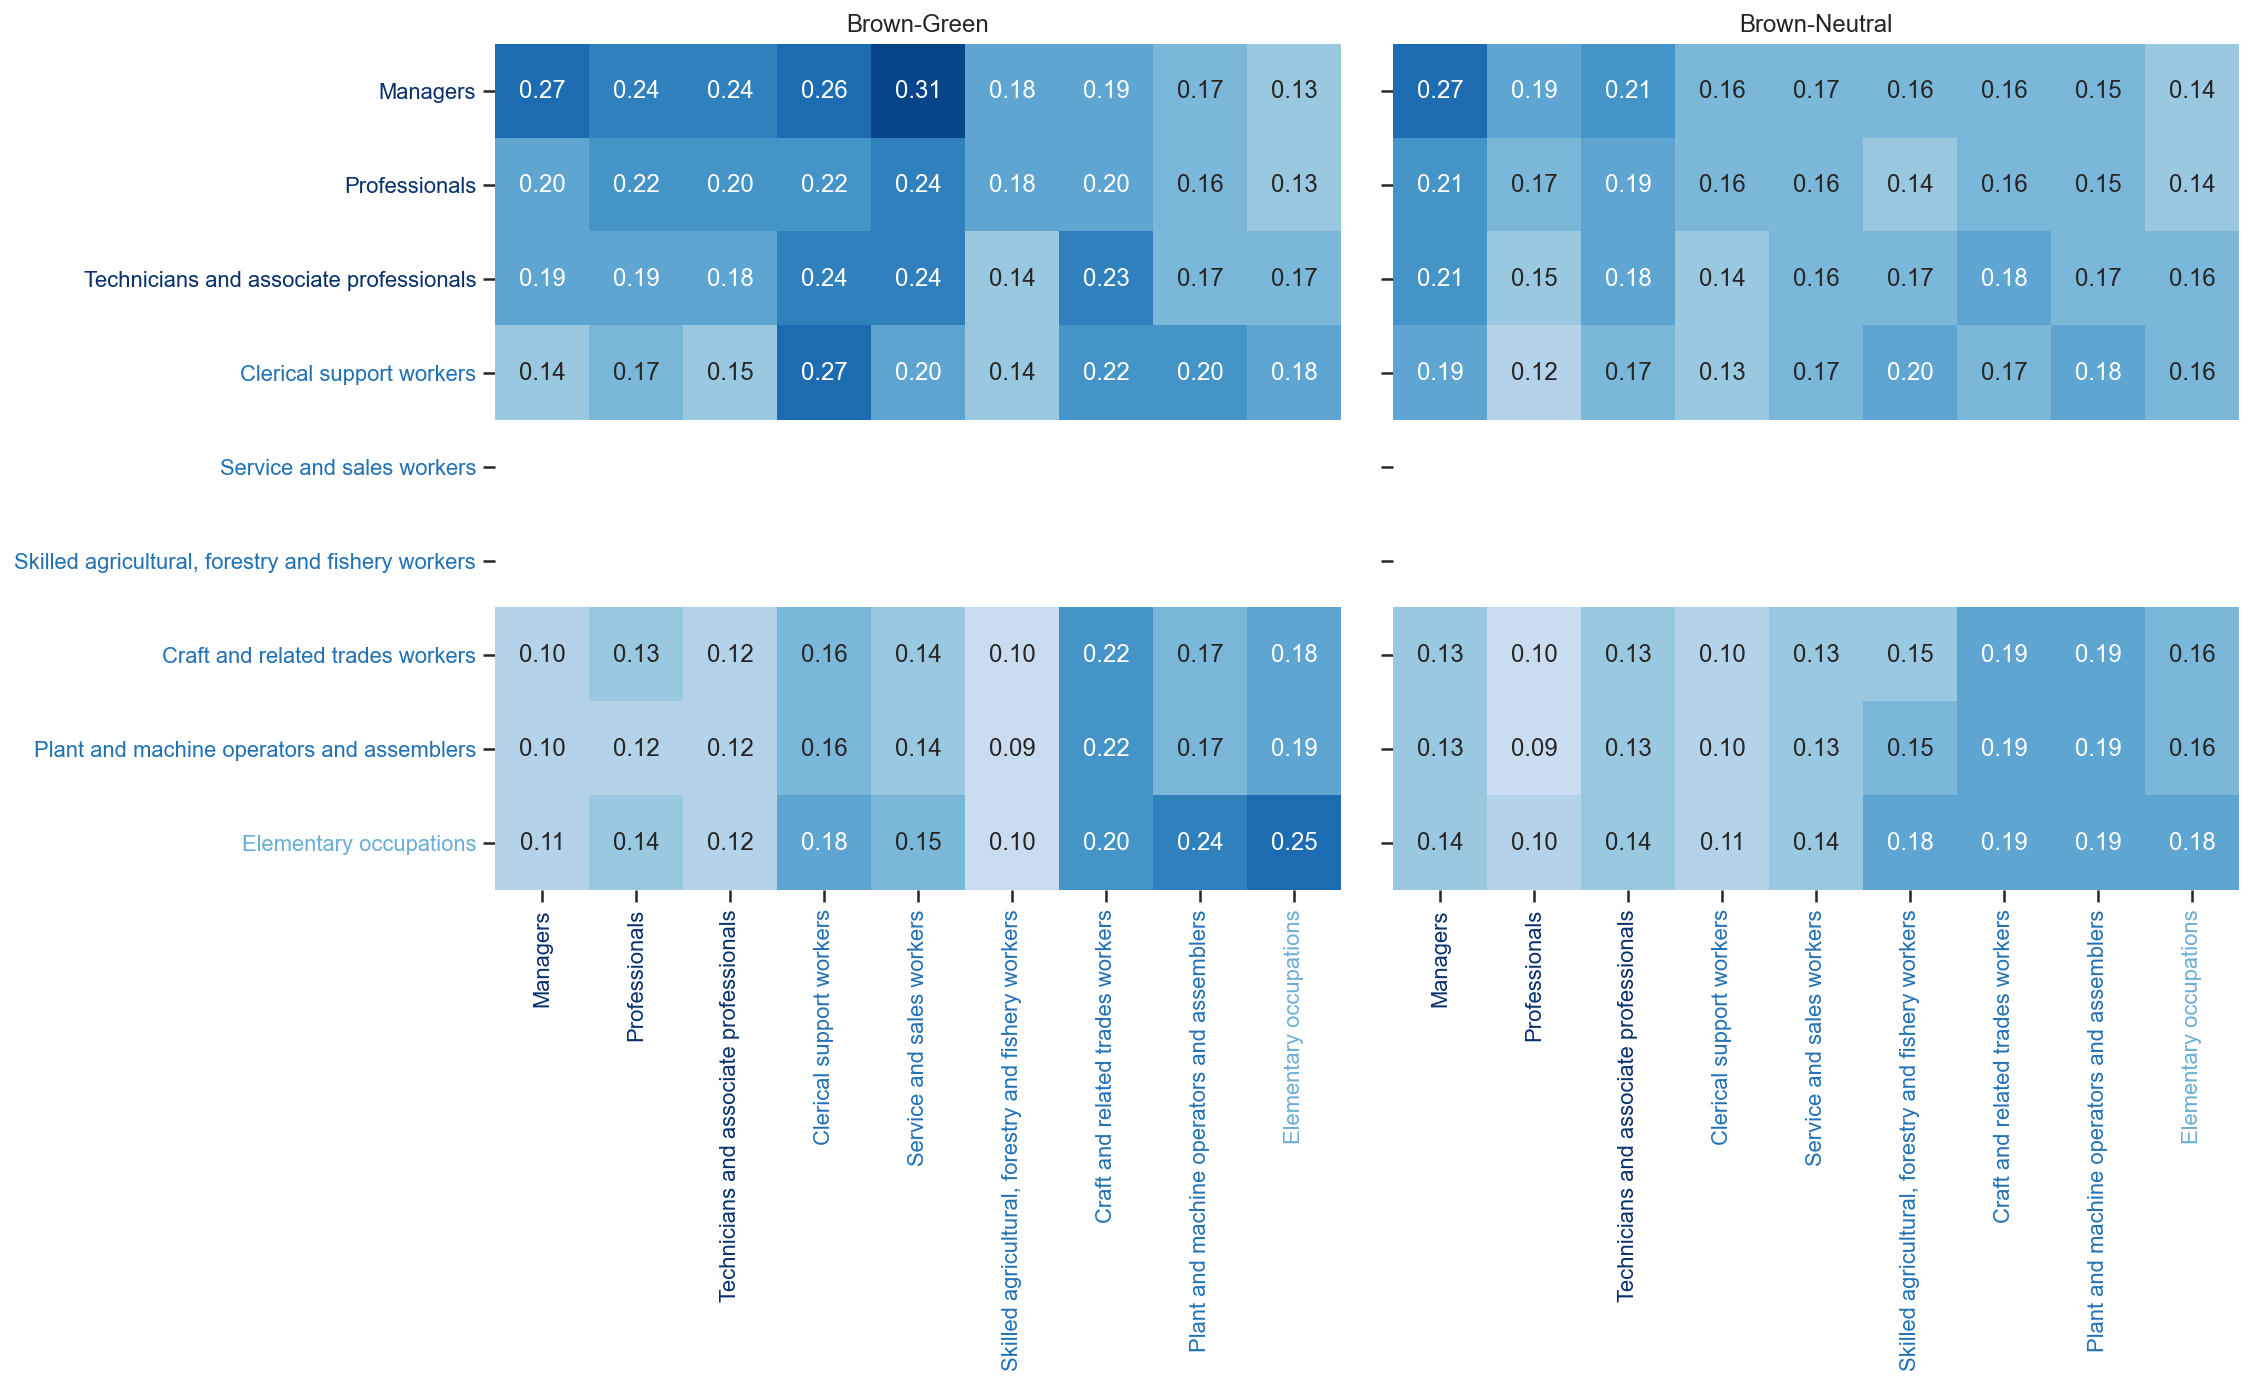

In [227]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)

# Brown - Green
df_results_bg = pd.DataFrame(
    mat_results_bg,
    index=list(isco_lvl1_mapping.values()),
    columns=list(isco_lvl1_mapping.values())
)

sns.heatmap(
    data=df_results_bg,
    cmap=plt.get_cmap("Blues", 14),
    vmin=0,
    vmax=0.35,
    annot=True,
    square=True,
    cbar=False,
    ax=ax1,
    fmt=".2f"
)

ax1.set_title("Brown-Green")
#plt.tight_layout()

#plt.savefig(
#    os.path.join(figure_dir, "RQ3", "avg_sims_heatmap_bg.png"),
#    bbox_inches="tight",
#    dpi=150
#)

# Brown - Neutral
df_results_bn = pd.DataFrame(
    mat_results_bn,
    index=list(isco_lvl1_mapping.values()),
    columns=list(isco_lvl1_mapping.values())
)

sns.heatmap(
    data=df_results_bn,
    cmap=plt.get_cmap("Blues", 14),
    vmin=0,
    vmax=0.35,
    annot=True,
    square=True,
    cbar=False,
    ax=ax2,
    fmt=".2f"
)

ax2.set_title("Brown-Neutral")

# color tick labels
for k, v in isco_lvl1_skill_level_colors.items():
    ax1.get_xticklabels()[k].set_color(v)
    ax1.get_yticklabels()[k].set_color(v)
    ax2.get_xticklabels()[k].set_color(v)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ3", "avg_sims_heatmap_combined.png"),
    bbox_inches="tight",
    dpi=150
)

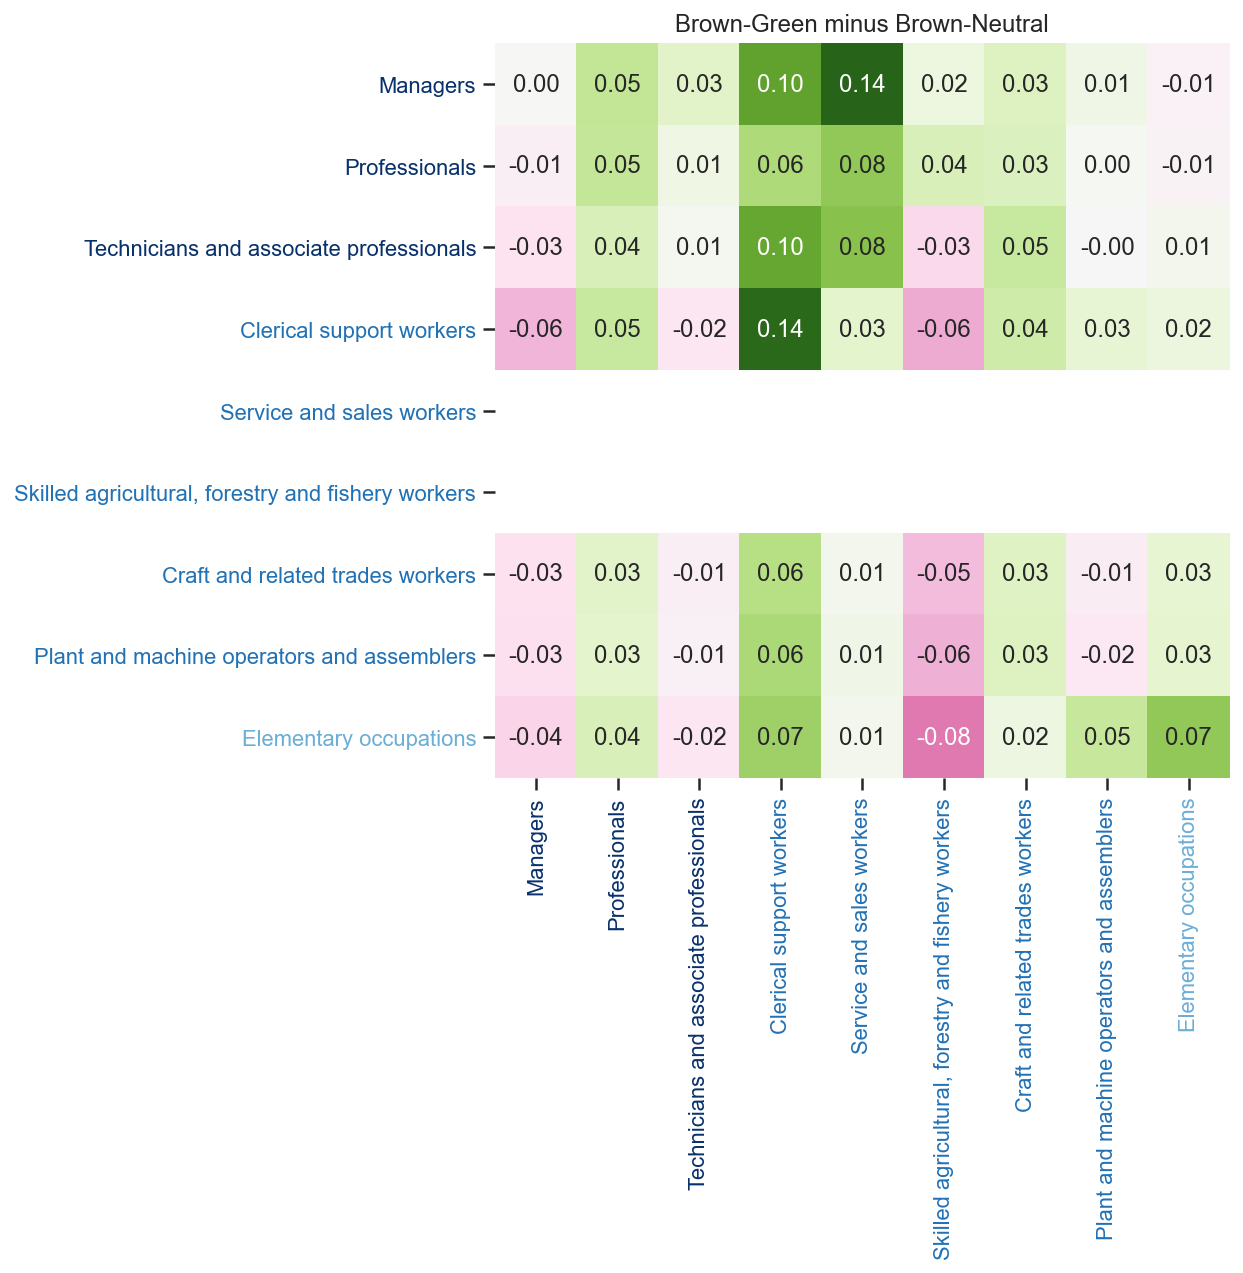

In [228]:
df_results_delta = df_results_bg - df_results_bn

ax = sns.heatmap(
    data=df_results_delta,
    cmap=plt.get_cmap("PiYG"),
    center=0,
    annot=True,
    square=True,
    cbar=False,
    fmt=".2f"
)

# color tick labels
for k, v in isco_lvl1_skill_level_colors.items():
    ax.get_xticklabels()[k].set_color(v)
    ax.get_yticklabels()[k].set_color(v)

ax.set_title("Brown-Green minus Brown-Neutral")
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "RQ3", "avg_sims_heatmap_bg_minus_bn.png"),
    bbox_inches="tight",
    dpi=150
)